In [193]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import os
from glob import glob
from evaluate import compute_sim, evaluate, l2norm_numpy
from evaluate import dict2list

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

infer_dirs = glob('infer/eval/*')[:]
# infer_dirs = infer_dirs[1:]
infer_dirs = [x for x in infer_dirs if 'bk' not in x]
weights = [1.0] * len(infer_dirs)
# weights = [1.0, 0.5, 0.5]

print(f"Ensemble of {len(infer_dirs)} models")

submit_file = f'submission.csv'
if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'

norm=True
method = 'cat'

def get_emb(infer_dirs, subset, weights):
    li = []
    for infer_dir in infer_dirs:
        if isinstance(subset, str):
            embs = pickle_load(f"{infer_dir}/{subset}_emb.pkl")
        else:
            embs = {}
            for s in subset:
                p = f"{infer_dir}/{s}_emb.pkl"
                if os.path.exists(p):
                    embs = {**embs, **pickle_load(p)}
                elif s != "val":
                    raise FileNotFoundError(p)

        li.append(embs)

    if len(li) == 1:
        return li[0]

    print(f'Ensemble from {len(infer_dirs)} models {infer_dirs}')
    li0 = li[0]
    di = {}
    for k in li0.keys():
        di[k] = []
        for i in range(len(li)):
            e = li[i][k]
            if norm:
                e = e / np.linalg.norm(e)
            di[k].append(e)
        
        if method == 'cat':
            di[k] = np.concatenate(di[k], 0)
        else:
            # Mean
            di[k] = np.mean(di[k], 0)

    return di

train_df = pd.read_csv('data/train_kfold.csv')

train_embs = get_emb(infer_dirs, 'train', weights)
# test_embs = get_emb(infer_dirs, 'test', weights)
val_embs = get_emb(infer_dirs, 'val', weights)

# train_embs = l2norm(train_embs)
# test_embs = l2norm(test_embs)
# val_embs = l2norm(val_embs)

Ensemble of 1 models


In [194]:
val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
spec_map = dict(zip(train_df.image, train_df.species))
id_map = {**train_map, **val_map}
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

import json

with open('individual_ids.json', 'r') as f:
    id2num = json.load(f)
    num2id = {v:k for k, v in id2num.items()}

from evaluate import compute_sim, evaluate, map_per_image, compute_simv2
from evaluate import *

# score, val_sim_df = evaluate(train_df, train_embs, val_embs, norm=True)
# val_sim_df["gt"] = val_sim_df.image.map(val_map)
# val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
# val_sim_df = val_sim_df.sort_values("map")
# print(score)

In [195]:
train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(val_embs)
class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))
print(train_v.shape, test_v.shape)
train_v = l2norm_numpy(train_v)
test_v = l2norm_numpy(test_v)
train_ids = np.unique([train_map[x] for x in train_k])
allowed = []
for i, k in enumerate(test_k):
    if train_map[k] in train_ids:
        allowed.append(i)
test_k, test_v = [test_k[i] for i in allowed], [test_v[i] for i in allowed]
cosines = np.matmul(test_v, train_v.T)

(40826, 512) (10207, 512)


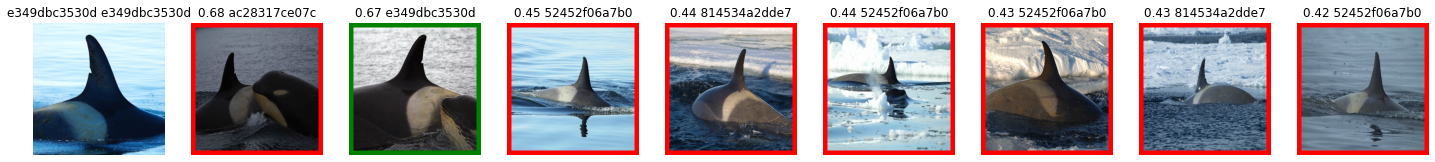

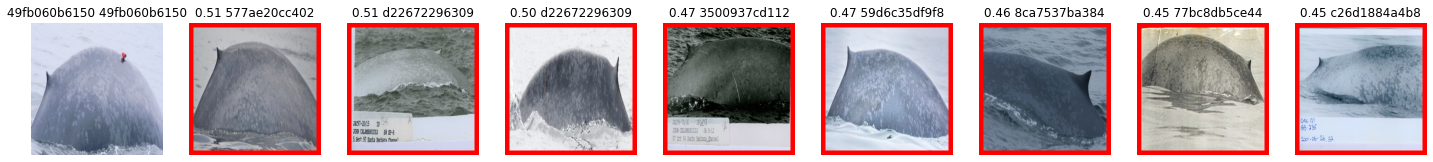

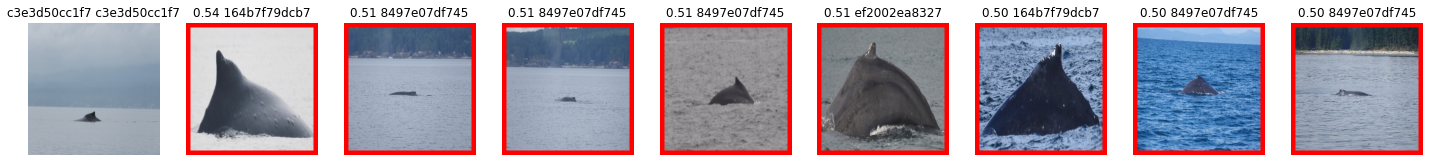

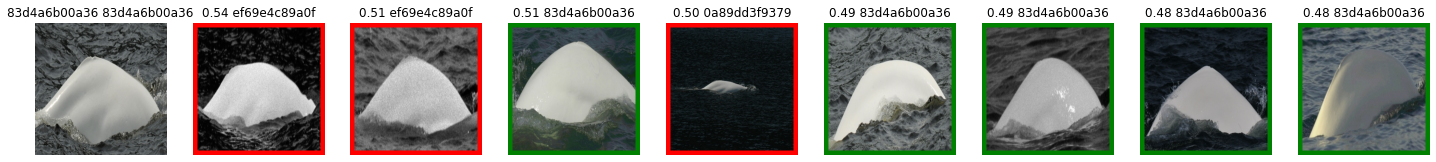

In [204]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

c = 0
for i, scores in enumerate(cosines):
    if np.random.rand() < 0.5:
        top = 8
        sort_idx = np.argsort(-scores)
        topk = [train_k[j] for j in sort_idx[:top]]
        topk_score = [scores[j] for j in sort_idx[:top]]
        topk_id = [train_map[x] for x in topk]
        qid = test_k[i]
        gt = train_map[qid]
        if gt == topk_id[0] or topk_score[0] <= 0.5:
            continue
        c+=1

        if c < 5:
            imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
            for k, l in zip(topk, topk_id):
                im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
                im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
                imgs.append(im)
            # Show image
            fig = plt.figure(figsize=(25, 4))
            columns = top + 1
            rows = 1
            for i2 in range(0, columns*rows):
                fig.add_subplot(rows, columns, i2+1)
                plt.title(f'{gt} {id_map[qid]}' if i2 == 0 else f'{topk_score[i2 - 1]:.2f} {id_map[topk[i2 -1]]}')
                plt.imshow(imgs[i2])
                plt.axis('off')
            
            plt.show()
        else:
            break

In [198]:
pred_list = []
for i, scores in enumerate(tqdm(cosines)):
    top = 10
    sort_idx = np.argsort(-scores)
    topk = [train_k[j] for j in sort_idx[:top]]
    topk_score = [scores[j] for j in sort_idx[:top]]
    topk_id = [train_map[x] for x in topk]
    qid = test_k[i]
    gt = train_map[qid]
    n_same = Counter(topk_id).most_common(1)[0][1]
    top5_correct = gt in topk_id[:5]
    pred_list.append([qid, gt, n_same, top5_correct] + topk_id + topk_score)
    
pred_df = pd.DataFrame(pred_list, columns=['image', 'gt', 'same', 'top5_correct'] +
                                          [f'top{i}' for i in range(10)] +
                                          [f'score{i}' for i in range(10)])
pred_df['correct'] = pred_df['gt'] == pred_df['top0']

100%|██████████| 8039/8039 [00:20<00:00, 386.97it/s]


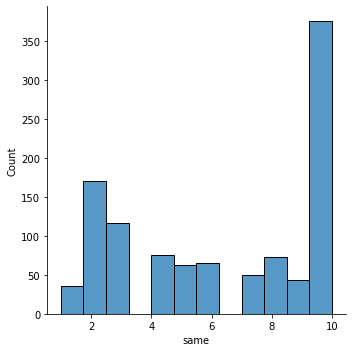

In [209]:
sns.displot(pred_df.query('~correct & score0 >=0.5')['same'])
# sns.displot(pred_df.query('~correct')['same'])

In [211]:
## TEST CV
from sklearn.neighbors import NearestNeighbors
n_neighbors = 100
knn = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine')

# val_pred = pickle_load(infer_dirs[0] + '/val_pred.pkl')
train_k, train_v = dict2list(train_embs)
# raw_val_embs = {k:v for k, v in raw_val_embs.items() if k in train_map}
val_k, val_v = dict2list(val_embs)
knn.fit(train_v)
train_v.shape, val_v.shape

((40826, 512), (10207, 512))

In [212]:
train_ids = np.unique([train_map[x] for x in train_k])
allowed = []
for i, k in enumerate(val_k):
    assert k in train_map, k
    if train_map[k] in train_ids:
        allowed.append(train_map[k])

val_targets_df = pd.DataFrame(val_k)
val_targets_df.columns = ['image']
val_targets_df['target'] = val_targets_df['image'].map(train_map)
val_targets_df.loc[~val_targets_df.target.isin(allowed),'target'] = 'new_individual'
val_target_map = dict(zip(val_targets_df['image'], val_targets_df['target']))
val_targets_df.head(3)

,image,target
0,00021adfb725ed.jpg,new_individual
1,108078c210e47e.jpg,1b434f154c89
2,106118de6ee46e.jpg,76b5aad6b790


In [247]:
distances, idxs = knn.kneighbors(val_v, 200, return_distance=True)

In [248]:

from tqdm import tqdm

val_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(val_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        # pred = val_pred[val_k[i]]
        # top1_idx = np.argmax(pred)
        # top1_conf = pred[top1_idx]
        # top1_pred = num2id[top1_idx]
        tar = img2id[img_id]
        # top1_pred, top1_conf
        val_df.append([val_k[i], tar, d]) 

val_df = pd.DataFrame(val_df, columns=['image', 'target', 'distances'])
raw_val_df = val_df.copy()
val_df['confidence'] = 1-val_df['distances']
val_df = val_df.groupby(['image','target']).confidence.max().reset_index()
val_df = val_df.sort_values('confidence',ascending=False).reset_index(drop=True)
val_df.to_csv('val_neighbors.csv')
val_df.head(3)

100%|██████████| 10207/10207 [00:03<00:00, 2773.83it/s]


,image,target,confidence
0,0e13f345b2a5aa.jpg,84502c5db6bc,0.999877
1,05b9a41635a275.jpg,ca69a5d7c122,0.999876
2,8bfcab40b2d550.jpg,bbeac4b2964e,0.999753


In [251]:
def mix_conf(row):
    # if row['confidence'] >= 0.7 and row['top1_conf'] >= 0.7 and row["target"] == row["top1_pred"]:
    #     return 1.0
    if row["target"] == row["top1_pred"]:
        return row['confidence'] + 0.01 * row['top1_conf']
    else:
        if row['top1_conf'] > 0.9:
            return row['confidence'] - 0.01 * row['top1_conf']
        return row['confidence']
        return row['confidence'] - 0.01 * row['top1_conf']
val_df['gt'] = val_df['image'].map(val_target_map)
# val_df['mix_conf'] = val_df.apply(mix_conf, axis=1)
val_df = val_df.sort_values('confidence',ascending=False).reset_index(drop=True)
val_df.head(3)

,image,target,confidence,gt
0,0e13f345b2a5aa.jpg,84502c5db6bc,0.999877,84502c5db6bc
1,05b9a41635a275.jpg,ca69a5d7c122,0.999876,ca69a5d7c122
2,8bfcab40b2d550.jpg,bbeac4b2964e,0.999753,bbeac4b2964e


In [252]:
from collections import Counter

def show_imgs_by_id(id):
    samples = train_df[train_df['individual_id'] == id].sample(5)
    imgs = []
    for i, row in samples.iterrows():
        imgs.append(readim(row['image'], ''))
    fig = plt.figure(figsize=(25, 4))
    columns = len(imgs)
    rows = 1
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.title(row["image"])
        plt.imshow(imgs[i])
        plt.axis('off')
    
    plt.show()

vdf = val_df[~val_df['image'].duplicated()]
vdf = vdf.query('gt != target & gt == "new_individual"')
# vdf.query('gt == "new_individual"')

# sns.distplot(vdf['top1_conf'])
# sns.distplot(vdf['confidence'])
# plt.show()
# print(Counter(vdf['target']).most_common(3))
# print(Counter(val_df['target']).most_common(3))

# vdf[vdf['target'] == 'dba4e482f0ad']
# show_imgs_by_id('dba4e482f0ad')

In [253]:
def accum(x):
    # if len(x) > 3 and np.max(x) < 0.51:
    #     return np.max(x) - 0.002 * len(x)
    r = np.sum([v ** (8 * (i + 1)) for i, v in enumerate(x)])
    return r

raw_val_df['confidence'] = 1 - raw_val_df['distances']
val_df = raw_val_df.groupby(['image','target']).confidence.max().reset_index()
val_df = val_df.sort_values(['confidence'], ascending=False).reset_index(drop=True)
val_df.head(3)

,image,target,confidence
0,0e13f345b2a5aa.jpg,84502c5db6bc,0.999877
1,05b9a41635a275.jpg,ca69a5d7c122,0.999876
2,8bfcab40b2d550.jpg,bbeac4b2964e,0.999753


In [254]:
print(len(val_targets_df[val_targets_df['target'] == 'new_individual']) / len(val_targets_df))
xt = val_df.groupby('image').confidence.max().reset_index()
for thr in np.arange(0.0, 0.55, 0.0001):
    r = len(xt[xt['confidence'] <= thr]) / len(xt)
    if abs(r - 0.22) < 0.005:
        print(f"THR: {thr}: {r}")
        break

0.21240325266973645
THR: 0.5116: 0.2150484961301068


In [255]:
def get_center(vectors):
    avg = np.mean(vectors, axis=0)
    if avg.ndim == 1:
        avg = avg / np.linalg.norm(avg)
    elif avg.ndim == 2:
        assert avg.shape[1] == 512
        avg = avg / np.linalg.norm(avg, axis=1, keepdims=True)
    else:
        assert False, avg.shape
    return avg

def get_nearest_k(center, features, k, threshold):
    feature_with_dis = [(feature, np.dot(center, feature)) for feature in features]
    if len(feature_with_dis) > 10:
        distances = np.array([dis for _, dis in feature_with_dis])

    filtered = [feature for feature, dis in feature_with_dis if dis > threshold]
    # if len(filtered) != len(feature_with_dis):
    #     print('filterd ', len(filtered), len(feature_with_dis))
    if len(filtered) < len(feature_with_dis):
        distances = np.array([feature for feature, dis in feature_with_dis if dis <= threshold])
    if len(filtered) > k:
        return filtered
    feature_with_dis = [feature for feature, dis in sorted(feature_with_dis, key=lambda v: v[1], reverse=True)]
    return feature_with_dis[:k]

def get_image_center(features):
    if len(features) < 4:
        return get_center(features)

    for _ in range(3):
        center = get_center(features)
        features = get_nearest_k(center, features, int(len(features) * 3 / 4), 0.5)
        # if len(features) < 4:
        #     break

    return get_center(features)


def compute_sim(train_df, train_embs, test_embs, thr=0.65, norm=False):
    # Compute center of each individual id
    label2emb = defaultdict(list)
    for label, d in train_df.groupby('individual_id'):
        for img_id in d.image.values:
            if img_id in train_embs:
                label2emb[label].append(train_embs[img_id])

    print(len(label2emb))
    for k, v in label2emb.items():
        # avg = np.mean(np.stack(v), 0)
        # label2emb[k] = avg / np.linalg.norm(avg)
        label2emb[k] = get_image_center(v)

    train_k, train_v = dict2list(label2emb)
    test_k, test_v = dict2list(test_embs)

    if norm:
        train_v = l2norm_numpy(train_v)
        test_v = l2norm_numpy(test_v)

    cos = np.matmul(test_v, train_v.T)

    records = []
    res2 = {}

    for thr in [thr]:
        for i, scores in enumerate(tqdm(cos)):
            sort_idx = np.argsort(scores)[::-1]
            top5 = [train_k[j] for j in sort_idx[:5]]
            top5_score = [scores[x] for x in sort_idx[:5]]

            res2[test_k[i]] = {k:v for k, v in zip(top5, top5_score)}

            if scores[sort_idx[0]] < thr:
                top5 = ['new_individual'] + top5[:4]
            else:
                top5 = top5[:1] + ['new_individual'] + top5[1:4]
            
            # print(test_k[i], [f"{train_k[j]}({scores[j]:.3f})" for j in sort_idx[:5]])
            # print(scores[-1])
            records.append([test_k[i], " ".join(top5)])


        sim_df = pd.DataFrame(records, columns=['image', 'predictions'])
        isnew = sim_df.predictions.str.startswith('new')
        # res2 = pd.DataFrame(res2, columns=['image', 'top5', 'score0', 'score1', 'score2', 'score3', 'score4'])
        print(isnew.mean(), thr)
    return sim_df, res2

# valpred2, top5_map = compute_sim(train_df, train_embs, val_embs, thr=thr, norm=False)

# all_preds = dict(zip(valpred2['image'], valpred2['predictions']))
# th = 0.5
# for i,row in val_targets_df.iterrows():
#         target = row.target
#         preds = all_preds[row.image].split(" ")
#         val_targets_df.loc[i,th] = map_per_image(target,preds)
# val_targets_df[th].mean()
# # 0.8237222820939878

In [256]:
def mix_conf(row):
    m = top5_map[row['image']].get(row['target'], 0.1)
    s = 0.7 * row['confidence'] + 0.3 * m
    return s
    
val_df['mix_conf'] = val_df.apply(mix_conf,axis=1)
val_df = val_df.sort_values('confidence', ascending=False).reset_index(drop=True)

In [257]:
val_pred = {}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

for i,row in tqdm(val_df.iterrows(), total=len(val_df)):
    if row.image in val_pred:
        if len(val_pred[row.image])==5:
            continue
        val_pred[row.image].append(row.target)
    elif row.confidence < 0:
        val_pred[row.image] = ['new_individual',row.target]
    else:
        val_pred[row.image] = [row.target,'new_individual']

for x in tqdm(val_pred):
    if len(val_pred[x])<5:
        remaining = [y for y in sample_list if y not in val_pred]
        val_pred[x] = val_pred[x]+remaining
        val_pred[x] = val_pred[x][:5]
    val_pred[x] = ' '.join(val_pred[x])
    
val_pred = pd.Series(val_pred).reset_index()
val_pred.columns = ['image','predictions']
val_pred.head()

all_preds = dict(zip(val_pred['image'], val_pred['predictions']))
th = 0.5
for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image].split(" ")
        val_targets_df.loc[i,th] = map_per_image(target,preds)
cv = val_targets_df[th].mean()
cv
# 0.8171271349727313

100%|██████████| 10207/10207 [00:00<00:00, 1271080.46it/s]


0.7544903824172953